In [1]:
import keras
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import cv2

from Pokemon import Pokemon
from process_pokemon import *
import pickle
% matplotlib inline

/home/ngundotra/.conda/envs/torchenv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
padded_data = []
mean = 0
for pair in data:
    biggest = max(max_w, max_h)
    new_pair = (pair[0], pad_data(pair[1], biggest, biggest))
    assert new_pair[1].shape == (biggest, biggest, 3), "Padding failed {}".format(new_pair[1].shape)
    padded_data.append(new_pair)

val = 0.2
train_idx = len(padded_data) * 0.2
train_idx = round(train_idx)
train_data = padded_data[:train_idx]
val_data = padded_data[train_idx:]

# normalize data
mean = 0
for img in (pair[1] for pair in train_data):
    mean += img.reshape(-1).mean()
mean /= train_idx
std = 0
for img in (pair[1] for pair in train_data):
    std += (img - mean).reshape(-1).mean()
std /= train_idx

normal_data = [] 
for pair in padded_data:
    img = (pair[1] - mean)/std
    normal_data.append((pair[0], img))

NameError: name 'data' is not defined

In [2]:
pokes = load_poke('pokemon.pickle')
poke_names, allChars, idx2Char = oneHotName(pokes)
padded_pics = getPaddedPics(pokes)
small_pics = getSmallPics(padded_pics)

35 tokens found
[' ', "'", '-', '.', '2', ':', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'é', '♀', '♂']


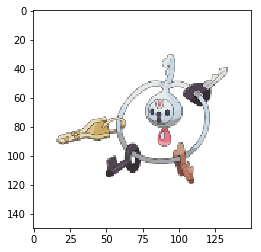

In [7]:
plt.imshow(small_pics[706])

In [7]:
poke_types, types, idx2Types = oneHotTypes(pokes)
print(poke_types[0])
print(types)
print(idx2Types)

#001: Bulbasaur
['Grass', 'Poison', 'Fire', 'Flying', 'Water', 'Bug', 'Normal', 'Electric', 'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Steel', 'Ice', 'Ghost', 'Dragon', 'Dark', 'None']
{'Grass': 0, 'Poison': 1, 'Fire': 2, 'Flying': 3, 'Water': 4, 'Bug': 5, 'Normal': 6, 'Electric': 7, 'Ground': 8, 'Fairy': 9, 'Fighting': 10, 'Psychic': 11, 'Rock': 12, 'Steel': 13, 'Ice': 14, 'Ghost': 15, 'Dragon': 16, 'Dark': 17, 'None': 18}


Tokenizing names

In [8]:
num_tok = len(all_tok)

# Now data is prepared for deep learning
deep_data = []
for pair in padded_data:
    name, img = pair
    name = name.lower()
    new_name = np.zeros((len(name), num_tok))
    for i, char in enumerate(name):
        new_name[i, char2idx[char]] = 1
    assert np.sum(np.sum(new_name)) == len(name)
    deep_data.append((new_name, img))

In [9]:
len(deep_data)

807

## Deep Learning Reacts?

In [10]:
from keras.layers import Input, Dense, Dropout, Conv2D, UpSampling2D, Flatten, Reshape, \
    MaxPool2D, BatchNormalization, Cropping2D
from keras.models import Model, Sequential
from keras.optimizers import RMSprop
from keras.backend import clear_session

## Autoencoding the Pictures

In [83]:
# simplifying pictures by croppping around the center & maxpooling
clear_session()
x_in = Input(shape=(biggest, biggest, 3))
x = Cropping2D(cropping=40)(x_in)
x = MaxPool2D()(x)
cropModel = Model(x_in, x)
cropped_pics = cropModel.predict(pics)
cropped_pics = cropped_pics - np.min(cropped_pics)
cropped_pics = cropped_pics / np.max(cropped_pics)
cropped_pics.shape

(807, 150, 150, 3)

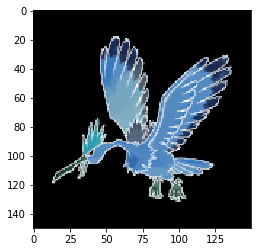

In [87]:
plt.imshow(cropped_pics[800])

In [118]:
x_in = Input(shape=(150, 150, 3))
x = Conv2D(32, (5, 5), padding='same', activation='relu')(x_in)
x = MaxPool2D()(x)
x = MaxPool2D()(x)
x = MaxPool2D()(x)
x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = UpSampling2D()(x)
x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = UpSampling2D()(x)
x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = UpSampling2D()(x)
x = keras.layers.ZeroPadding2D(padding=(3, 3))(x)
x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = Conv2D(3, (3,3), padding='same', activation='sigmoid')(x)
baseline = Model(x_in, x)
baseline.summary()
baseline.compile(optimizer=RMSprop(1e-3), loss='binary_crossentropy')
baseline.fit(cropped_pics, cropped_pics, epochs=30)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 18, 18, 128)       36992     
_________________________________________________________________
up_sampling2d_39 (UpSampling (None, 36, 36, 128)       0         
__________

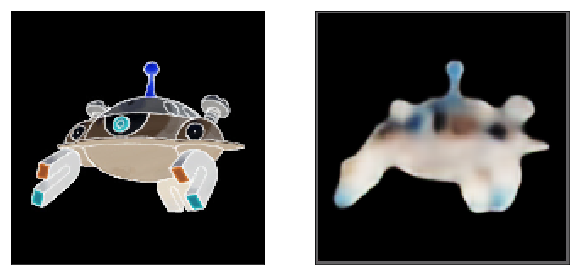

In [117]:
def plot_idx(idx):
    fig, axes = plt.subplots(ncols=2, figsize=(10, 8))
    axes[0].imshow(cropped_pics[idx])
    axes[1].imshow(baseline.predict(cropped_pics[idx:idx+1])[0])
    for ax in axes:
        ax.set_yticks([])
        ax.set_xticks([])
    plt.show(fig)
plot_idx(70)

In [ ]:
plt

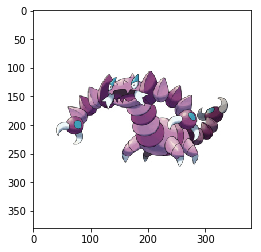

In [50]:
asd = padded_data[0][1]
plt.imshow(asd)

In [27]:
normal_data[0][1].shape

(380, 380, 3)

In [11]:
clear_session()

x_in = Input(shape=(biggest, biggest, 3))
x = Conv2D(64, (5, 5), padding='valid', activation='relu')(x_in)
x = Conv2D(64, (5, 5), padding='valid', activation='relu')(x)
x = MaxPool2D()(x) # 190 x 190 x 256
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D()(x) # 95 x 95 x 256
x = Conv2D(128, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D()(x) # 40 x 40 x 256
x = Conv2D(256, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D()(x) # 20 x 20 x 256

encoder = Model(x_in, x)

# Decoder goes from (20, 20, 16) to (380, 380, 3)
def upsample_block(filters, kernels, x):
    x = Conv2D(filters[0], kernels[0], padding='same', activation='relu')(x)
    x = Conv2D(filters[1], kernels[1], padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D()(x)
    return x

d_in = Input(shape=(20, 20, 64))
x = upsample_block((256, 64), ((5,5), (5,5)), d_in) # 40
x = upsample_block((64, 64), ((5,5), (5,5)), x) # 80
x = UpSampling2D()(x)
x = upsample_block((64, 16), ((3,3), (3,3)), x) # 320
x = UpSampling2D()(x) # 640
# Want 380 x 380
buff = (640 - biggest) // 2
x = Cropping2D(cropping=buff)(x)
x = Conv2D(8, (3,3), padding='same', activation='relu')(x)
x = Conv2D(3, (3,3), padding='same', activation='sigmoid')(x)
decoder = Model(d_in, x)

autoencoder = Model(x_in, decoder(encoder.output))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [12]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 20, 256)       409856    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 20, 20, 64)        409664    
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 20, 64)        256       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 40, 40, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 40, 40, 64)        102464    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 40, 40, 64)        102464    
__________

In [13]:
pics = [data[1] for data in normal_data]
pics = np.array(pics)
print(pics.shape)

(807, 380, 380, 3)


In [14]:
def plot(pics):
    idx = np.random.choice(len(pics), size=4)
    imgs = pics[idx]
    ys = autoencoder.predict(imgs)
    fig, axes = plt.subplots(nrows=2, ncols=4)
    for i in range(4):
        top = axes[0, i]
        bot = axes[1, i]
        y = ys[i]
        img = imgs[i]
        top.imshow(y)
        bot.imshow(img*std + mean)
        for ax in (top, bot):
            ax.set_xticks([])
            ax.set_yticks([])
    fig.savefig("plotsave.png", figsize=(8, 4), dpi=150)
    plt.close(fig)

callback = keras.callbacks.LambdaCallback(on_epoch_begin=lambda batch, logs: plot(pics[:12]))


Epoch 1/200
5/5 [==============================] - 3s 615ms/step - loss: -103299248291840.0000
Epoch 2/200
5/5 [==============================] - 0s 90ms/step - loss: 14752085442560.0000
Epoch 3/200
5/5 [==============================] - 0s 89ms/step - loss: -655900226355200.0000
Epoch 4/200
5/5 [==============================] - 0s 94ms/step - loss: 422402852913152.0000
Epoch 5/200
5/5 [==============================] - 1s 103ms/step - loss: -981628331491328.0000
Epoch 6/200
5/5 [==============================] - 0s 90ms/step - loss: -1958724532961280.0000
Epoch 7/200
5/5 [==============================] - 0s 93ms/step - loss: -2959196228157440.0000
Epoch 8/200
5/5 [==============================] - 0s 92ms/step - loss: -3960556042059776.0000
Epoch 9/200
5/5 [==============================] - 0s 96ms/step - loss: -5023672922275840.0000
Epoch 10/200
5/5 [==============================] - 0s 92ms/step - loss: 433778476449792.0000
Epoch 11/200
5/5 [==============================] - 0s 92

Epoch 87/200
5/5 [==============================] - 0s 87ms/step - loss: -7967126753116160.0000
Epoch 88/200
5/5 [==============================] - 0s 88ms/step - loss: -7970287849046016.0000
Epoch 89/200
5/5 [==============================] - 0s 86ms/step - loss: -7971876986945536.0000
Epoch 90/200
5/5 [==============================] - 0s 88ms/step - loss: -7977125436981248.0000
Epoch 91/200
5/5 [==============================] - 0s 88ms/step - loss: -7980056215289856.0000
Epoch 92/200


KeyboardInterrupt: 

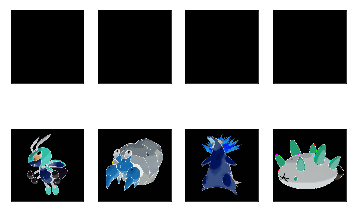

In [15]:
autoencoder.fit(pics[:5], pics[:5], callbacks=[callback], batch_size=10, epochs=200)

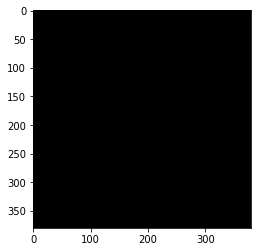

In [19]:
plt.imshow(autoencoder.predict(pics[:3])[2])